## This is an example how to use a simple fitter for 0vbb fits

First, let's load simple plotting tools etc. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize']=[15.0,12.0]
plt.rcParams['axes.linewidth']=2
plt.rcParams['xtick.major.size']=6
plt.rcParams['xtick.major.width']=2
plt.rcParams['xtick.minor.size']=4
plt.rcParams['xtick.minor.width']=2
plt.rcParams['ytick.major.size']=6
plt.rcParams['ytick.major.width']=2
plt.rcParams['ytick.minor.size']=4
plt.rcParams['ytick.minor.width']=2
plt.rcParams['xtick.labelsize']=16
plt.rcParams['ytick.labelsize']=16
plt.rcParams['axes.labelsize'] =24
plt.rcParams['legend.fontsize']= 24
plt.rcParams['legend.framealpha'] = 0.95
plt.rcParams['legend.handlelength']=2.0
plt.rcParams['figure.facecolor']="w"
plt.rcParams['xtick.direction']= 'in'
plt.rcParams['ytick.direction']= 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

### Loading the fitter itself, please change your path accordingly

In [3]:
import sys, os
sys.path.append("/home/pat/terliuk/software/DARWIN/DecayFitter/")
from AnalyticCalculator import AnalyticCalculator
from BinnedFitter import BinnedFitter

### Now let's create loader  object

In [20]:
bin_edges = np.linspace(2435.0,2481.0,2) # creating one bin between 2435 and 2481 keV
livetime = 2.0 # number of years
### analytic calcuator to get the exectation

loader = AnalyticCalculator(bin_edges =bin_edges, 
                            livetime=livetime, 
                            Xe136eff = 1.0) # efficiency for Xe reconstruction
# Injecting the values,
# Amplitudes for gaussian bkg (start with A) define a total number of events/t/y 
# XXX: WARNING, amplitudes are given for total and not ROI event counts
inject_values = {"AXe136" : 0.0,  
                 "ABi214" : 0.331, 
                 "flatRate" : 0.00194 # 
                 }  
# Getting the expectation  for "Asimov" estimates
total_rate = loader.getBinnedExpectation(**inject_values)

### Creating fitter object and giving the values 

In [21]:
# initializing fitter 
fitter = BinnedFitter(loader=loader)
# Giving starting values for the fit, 
# the second value defines whether parameter is fixed (True) or free (False) 
fit_settings = {"AXe136"   : [ 0.5,    False] , 
                "ABi214"   : [ 0.331,  True ], 
                "flatRate" : [ 0.00194, True]}
# giving the priors, first value = mean, second = gaussian sigma
# Priors are gaussian for now, but we can implement any priors if necessary 
# now the sigmas are very small = effectively fixed parameters
priors = {"ABi214"   : [  0.331,    0.001*0.331], 
          "flatRate" : [0.00194,    0.001*0.00194 ]}

### Making a simple fit

In [22]:
# running the fit 
result = fitter.FitValue(total_rate, 
                fitvalues=fit_settings, 
                errors = {"AXe136": 0.01}, 
                priors = priors,     
                ftol=1e-5,
                verbosity = 0
               )
# printing the results 
for key in result.keys(): 
    print(key.ljust(12), result[key])

AXe136       1.8772859489146754e-08
ABi214       0.331
flatRate     0.00194
valid        True
LLH          -8.413849146646216


### And making a simple scan as function of amplitue

In [23]:
# Now we can make a simple scan for Xe136 amplitude
AXe136_scan_vals = np.linspace(0.0,1.0,101)
LLH_results = np.nan*np.ones_like(AXe136_scan_vals)
for i in range(len(AXe136_scan_vals)):
    cur_fset = dict(fit_settings)
    cur_fset['AXe136'] = [AXe136_scan_vals[i], True] # fixing the value to make profile LLH
    #print(cur_fset['AXe136'] )
    n_free = 0
    for fpar in cur_fset.keys():
        n_free += (cur_fset[fpar][1]==False)
    #print("Free parameters ", n_free)
    if n_free >= 0 :
        cur_res = fitter.FitValue(total_rate, 
                fitvalues=cur_fset, 
                errors = {"AXe136": 0.01}, 
                priors = priors,
                ftol=1e-5,
                verbosity = 0
                )
        LLH_results[i] = cur_res["LLH"]
    else: 
        cur_pars = {}
        for fpar in cur_fset.keys():
            cur_pars[fpar] = cur_fset[fpar][0]
        LLH_results[i]  = fitter.LLH(**cur_pars[fpar])
    

### And plotting everything

Text(0.72, 2.76, '90% C.L. ')

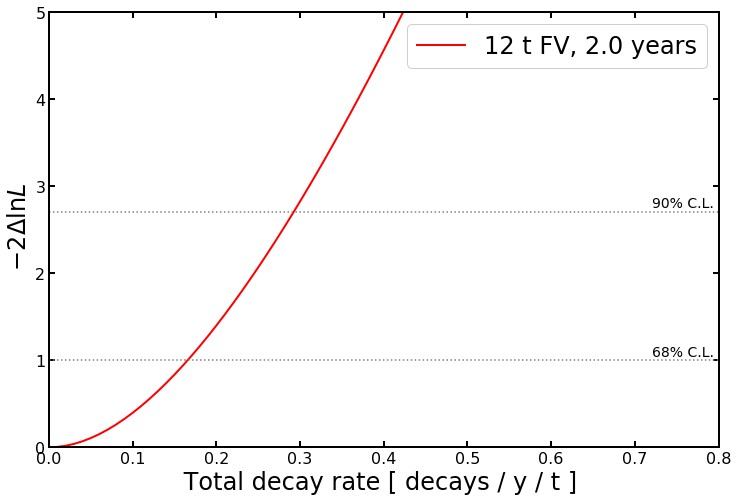

In [24]:
# And plotting the scan 

fig = plt.figure(figsize = (12,8))
ax= fig.add_subplot(111)
ax.plot(AXe136_scan_vals , 2.0 * (LLH_results  - result['LLH']), lw=2, c = "r", label = "12 t FV, %0.1f years"%livetime )
plt.axhline(1.0, c= "0.5", ls =":")
plt.axhline(2.71, c= "0.5", ls =":")

#ax.set_xscale("log")
ax.set_ylim(0, 5)
ax.set_xlim(0, 0.8)
ax.set_ylabel(r" $ - 2 \Delta \ln L $")
ax.set_xlabel(r" Total decay rate [ decays / y / t ]  ")
ax.legend()
ax.text(0.72, 1.05, "68% C.L. ", fontsize=14)
ax.text(0.72, 2.76, "90% C.L. ", fontsize=14)

/misc/home/pat/terliuk/test_venv/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


Text(16.0, 2.76, '90% C.L. ')

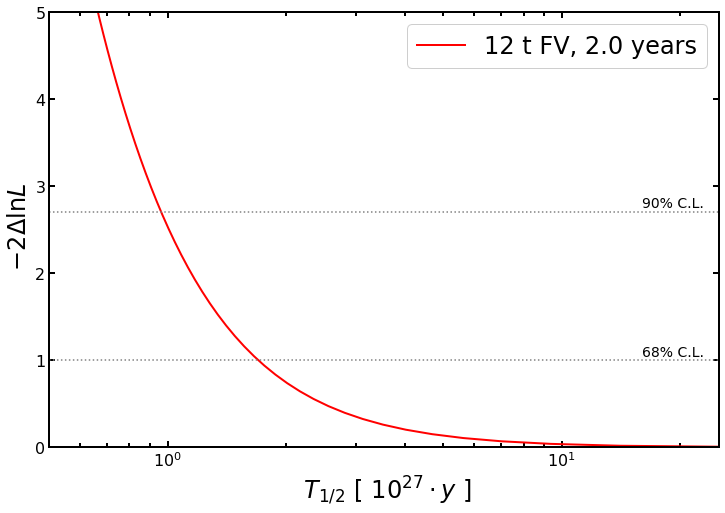

In [25]:
# we can also plot it as a function of half life 
# For this, we need to convert it using the formula 
# T_{1/2} = ln(2) / A * abundance * N_A / M_Xe
# With numbers plugged in 
# np.log(2)*6.0214/131.293*8.8573 = 0.28157 
# T_{1/2} [10^{27} y ] \approx  0.28157 / A [ ev / y / t ] 
T_1_2 = 0.28157 / AXe136_scan_vals


fig = plt.figure(figsize = (12,8))
ax= fig.add_subplot(111)
ax.plot(T_1_2 , 2.0 * (LLH_results  - result['LLH']), lw=2, c = "r", label = "12 t FV, %0.1f years"%livetime )
plt.axhline(1.0, c= "0.5", ls =":")
plt.axhline(2.71, c= "0.5", ls =":")

ax.set_xscale("log")
ax.set_ylim(0, 5)
ax.set_xlim(0.5, 25)
ax.set_ylabel(r" $ - 2 \Delta \ln L $")
ax.set_xlabel(r" $T_{1/2}\ [\ 10^{27} \cdot y\ ] $")
ax.legend()
ax.text(16.0, 1.05, "68% C.L. ", fontsize=14)
ax.text(16.0, 2.76, "90% C.L. ", fontsize=14)

###  And now, let's get the resulting livetime 

In [30]:
from scipy.interpolate import interp1d
from scipy.optimize import root

# Creating spline 
doubleLLH_profile = interp1d(T_1_2[1:], 2.0 * (LLH_results  - result['LLH'])[1:]) 
critical_value = 2.71 # This is critical value for xi^2 with 1 dof for 90% C.L. 
halflife_result =  root(lambda x: doubleLLH_profile(x) - critical_value, 1.0 ) 

In [31]:
print( "Resuling sensitivity: %0.3f  [ 10^27 years ] \n"% halflife_result['x'])
print("--- output from root finding algorithm ---")
print(halflife_result)

Resuling sensitivity: 0.962  [ 10^27 years ] 

--- output from root finding algorithm ---
    fjac: array([[-1.]])
     fun: array([-4.4408921e-16])
 message: 'The iteration is not making good progress, as measured by the \n  improvement from the last ten iterations.'
    nfev: 16
     qtf: array([4.4408921e-16])
       r: array([9.77625034])
  status: 5
 success: False
       x: array([0.96248672])
